#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**

In [ ]:
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from typing import List

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

#Implementacja

In [ ]:

class NaiveBayes:
    def __init__(self) -> None:
        self.priors = {}
        self.likelihoods = np.array([])

    def build_classifier(self, train_features: np.ndarray, train_classes: np.ndarray, discretization_classes_number: int = 4) -> np.ndarray:
        unique_classes_list, classes_counts = np.unique(train_classes, return_counts=True)
        for unique_class, class_count in zip(unique_classes_list, classes_counts):
          self.priors[unique_class] = class_count/len(train_classes)

        self.likelihoods = np.zeros([len(np.unique(train_classes)), np.shape(train_features)[1], discretization_classes_number])

        for feature_key in range(np.shape(train_features)[1]):
          for discretization_class in range(discretization_classes_number):
            class_indexes = np.where(train_features[:, feature_key] == discretization_class)
            for class_index in class_indexes[0]:
              self.likelihoods[train_classes[class_index], feature_key, discretization_class] += 1
        self.likelihoods /= len(train_classes)

    @staticmethod
    def data_discretization(data: np.ndarray, discretization_classes_number: int = 4) -> np.ndarray:
        output_data = np.zeros(data.shape)
        for i in range(len(data[0])):
          class_edges = np.linspace(data[:, i].min(), data[:, i].max(), discretization_classes_number)
          output_data[:, i] = np.digitize(data[:, i], bins=class_edges, right = True)
        return output_data

    def predict(self, sample: np.ndarray) -> List:
      #  Logarytmy tu nie działały bo czasami likelihoods były = 0
        output = []
        for class_type in range(np.shape(self.likelihoods)[0]):
          output.append(self.priors[class_type])
          for feture_index in range(len(sample)):
            output[class_type] *= self.likelihoods[class_type, feture_index, int(sample[feture_index])]
        return output


class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = np.array([])

    def build_classifier(self, train_features: np.ndarray, train_classes: np.ndarray) -> np.ndarray:
        unique_classes_list, classes_counts = np.unique(train_classes, return_counts=True)
        for unique_class, class_count in zip(unique_classes_list, classes_counts):
          self.priors[unique_class] = class_count/len(train_classes)

        self.likelihoods = np.zeros([len(np.unique(train_classes)), np.shape(train_features)[1], 2])

        for train_class in np.unique(train_classes):
          for feature_key in range(len(train_features[0])):
            class_indexes = np.where(train_classes == train_class)
            average = np.average(train_features[class_indexes, feature_key])
            std = np.std(train_features[class_indexes, feature_key])
            self.likelihoods[train_class, feature_key] = np.array([average, std])

    @staticmethod
    def normal_dist(x: float, mean: float, std: float) -> float:
        distribution = 1/(std*math.sqrt(2*math.pi))
        distribution = distribution * math.e **(-0.5*((x-mean)/std)**2)
        return distribution

    def predict(self, sample: np.ndarray)-> List:
        output = []
        for class_type in range(np.shape(self.likelihoods)[0]):
          output.append(math.log(self.priors[class_type]))
          for feture_index in range(len(sample)):
            if GaussianNaiveBayes.normal_dist(sample[feture_index], *self.likelihoods[class_type, feture_index]) == 0:
              continue
            output[class_type] += math.log(GaussianNaiveBayes.normal_dist(sample[feture_index], *self.likelihoods[class_type, feture_index]))
        return output


In [ ]:
def get_discreate_bayesian_naive_accuracy(x_train: np.ndarray, x_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray, discretization_classes: int = 4) -> List[float]:
  clasifier = NaiveBayes()
  clasifier.build_classifier(NaiveBayes.data_discretization(x_train, discretization_classes), y_train, discretization_classes)
  correct_test = 0
  for x_t, y_t in zip(NaiveBayes.data_discretization(x_test, discretization_classes), y_test):
    if np.argmax(clasifier.predict(x_t)) == y_t:
      correct_test += 1

  correct_train = 0
  for x_t, y_t in zip(NaiveBayes.data_discretization(x_train, discretization_classes), y_train):
    if np.argmax(clasifier.predict(x_t)) == y_t:
      correct_train += 1
  return [correct_train/len(y_train), correct_test/len(y_test)]

def get_gausian_bayesian_naive_accuracy(x_train: np.ndarray, x_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray) -> List[float]:
  clasifier = GaussianNaiveBayes()
  clasifier.build_classifier(x_train, y_train)
  correct_test = 0
  for x_t, y_t in zip(x_test, y_test):
    if np.argmax(clasifier.predict(x_t)) == y_t:
      correct_test += 1

  correct_train = 0
  for x_t, y_t in zip(x_train, y_train):
    if np.argmax(clasifier.predict(x_t)) == y_t:
      correct_train += 1
  return [correct_train/len(y_train), correct_test/len(y_test)]

#Test dla przykładowego zbioru

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
accuracy_train_discrete, accuracy_test_discrete = get_discreate_bayesian_naive_accuracy(x_train, x_test, y_train, y_test)

accuracy_train_gausian, accuracy_test_gausian = get_gausian_bayesian_naive_accuracy(x_train, x_test, y_train, y_test)
print(f"Klasyfikator naiwny dyskretny, dokładność na zbiorze treningowym: {accuracy_train_discrete}, dokładność na zabiorze testowym {accuracy_test_discrete}")
print(f"Klasyfikator naiwny gausowski, dokładność na zbiorze treningowym: {accuracy_train_gausian}, dokładność na zabiorze testowym {accuracy_test_gausian}")

Klasyfikator naiwny dyskretny, dokładność na zbiorze treningowym: 0.9703703703703703, dokładność na zabiorze testowym 0.9333333333333333
Klasyfikator naiwny gausowski, dokładność na zbiorze treningowym: 0.9555555555555556, dokładność na zabiorze testowym 1.0


Kroswalidacja

#Test ilości dyskretnych klas


Testy zostały przeprowadzone przy pomocy stałego podziału, aby jedyną zmienną była ilośc dyskretnych klas

Text(0.5, 1.0, 'Comparison of different number of discretization classes for static random state')

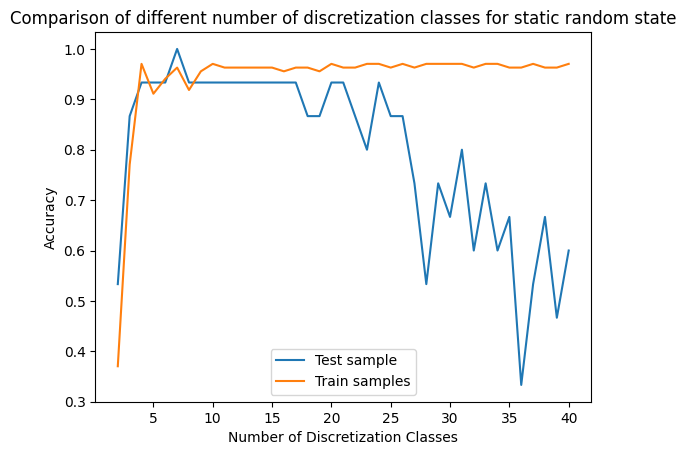

In [ ]:
max_discretization_class = 40
accuracy = np.zeros((max_discretization_class+1, 2))
for disc_class_number in range(2, max_discretization_class + 1):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
  accuracy[disc_class_number] += np.array(get_discreate_bayesian_naive_accuracy(x_train, x_test, y_train, y_test, disc_class_number))
plt.plot(range(2, max_discretization_class + 1), accuracy[2:, 1])
plt.plot(range(2, max_discretization_class + 1), accuracy[2:, 0])
plt.xlabel("Number of Discretization Classes")
plt.ylabel("Accuracy")
plt.legend(["Test sample", "Train samples"])
plt.title("Comparison of different number of discretization classes for static random state")

Przy zwiększającej się liczbie klass dyskretyzacji dokładność, zbioru testowego rośnie i powyżeji 10 klas dyskretyzacji pozostaje taka sama. Natomiast dla zbioru testowego dokładność wzrasta, następnie dla 4 klas wypłaszcza się, aby potem dla 16 klas opadać z dużymi fluktuacjami. Jest to spowodowane faktem, że dla większej ilości klas zbiór testowy mniej dokładnie się dzieli względem zbioru treningowego (bo dyskretyzujemy je oddzielnie)

Text(0.5, 1.0, 'Comparison of different number of discretization classes')

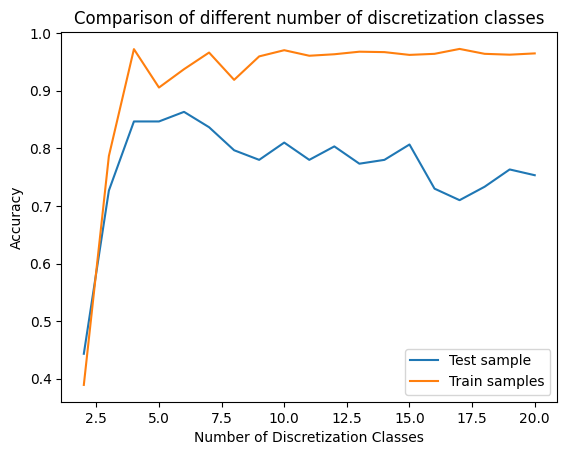

In [ ]:
max_discretization_class = 20
retries = 20
accuracy = np.zeros((max_discretization_class+1, 2))
for disc_class_number in range(2, max_discretization_class + 1):
  for retry in range(retries):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    accuracy[disc_class_number] += np.array(get_discreate_bayesian_naive_accuracy(x_train, x_test, y_train, y_test, disc_class_number))
plt.plot(range(2, max_discretization_class + 1), accuracy[2:, 1]/retries)
plt.plot(range(2, max_discretization_class + 1), accuracy[2:, 0]/retries)
plt.xlabel("Number of Discretization Classes")
plt.ylabel("Accuracy")
plt.legend(["Test sample", "Train samples"])
plt.title("Comparison of different number of discretization classes")

Text(0.5, 1.0, 'Comparison of different number of discretization classes')

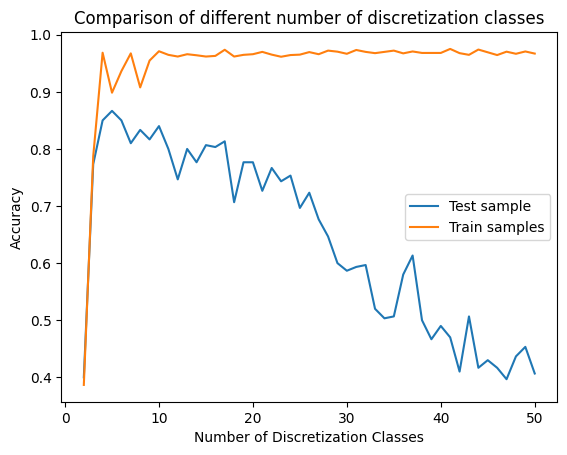

In [ ]:
max_discretization_class = 50
retries = 20
accuracy = np.zeros((max_discretization_class+1, 2))
for disc_class_number in range(2, max_discretization_class + 1):
  for retry in range(retries):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    accuracy[disc_class_number] += np.array(get_discreate_bayesian_naive_accuracy(x_train, x_test, y_train, y_test, disc_class_number))
plt.plot(range(2, max_discretization_class + 1), accuracy[2:, 1]/retries)
plt.plot(range(2, max_discretization_class + 1), accuracy[2:, 0]/retries)
plt.xlabel("Number of Discretization Classes")
plt.ylabel("Accuracy")
plt.legend(["Test sample", "Train samples"])
plt.title("Comparison of different number of discretization classes")

W przypadku uśrednionych wartości dla różnych random_state, widzimy podobną zależność tylko przebieg zaczyna opadać znacznie szybciej i ma też mniejsze maksimum. Jest to częściowo sopwodowane małą wielkością zbioru, ponieważ wtedy zbiór treningowy jest na tyle mły, że ni można dokładnie podzielić go na klasy i często te same wartości danego atrybutu otrzymują inne klasy. Zwiększenie zbioru danych pomogłoby w tym, ale wydłużyłaby czas obliczeń.

#Porówanie algorytmów dla różnych podziałó testowych

In [ ]:
def compare_algorithms_test_splits(x, y, test_splits, retries = 20):
  accuracy = np.array([])
  gausian_accuracy = np.array([])
  for test_split in test_splits:
    accuracy = np.append(accuracy, 0)
    gausian_accuracy = np.append(gausian_accuracy, 0)
    for retry in range(retries):
      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_split)
      gausian_accuracy[-1] += get_gausian_bayesian_naive_accuracy(x_train, x_test, y_train, y_test)[1]
      accuracy[-1] += get_discreate_bayesian_naive_accuracy(x_train, x_test, y_train, y_test)[1]
  return accuracy, gausian_accuracy


<ipython-input-2-2bf1e89b2f7f>:72: RuntimeWarning: divide by zero encountered in double_scalars
  distribution = 1/(std*math.sqrt(2*math.pi))
<ipython-input-2-2bf1e89b2f7f>:73: RuntimeWarning: divide by zero encountered in double_scalars
  distribution = distribution * math.e **(-0.5*((x-mean)/std)**2)
<ipython-input-2-2bf1e89b2f7f>:73: RuntimeWarning: invalid value encountered in double_scalars
  distribution = distribution * math.e **(-0.5*((x-mean)/std)**2)


Text(0.5, 1.0, 'Comparison of different test sizes')

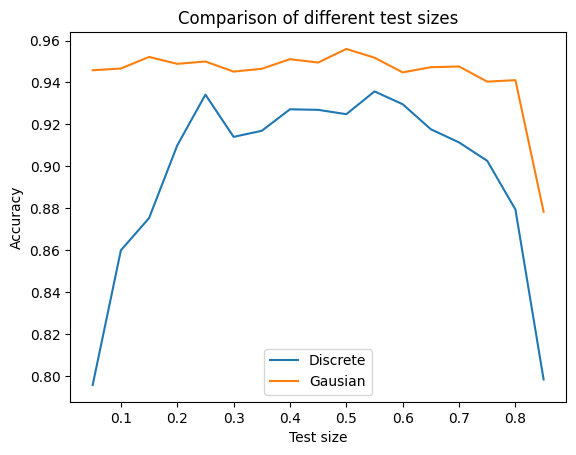

In [ ]:
test_splits = np.linspace(0.05, 0.85, num=17)
retries = 30
accuracy, gausian_accuracy = compare_algorithms_test_splits(x, y, test_splits, retries)
plt.plot(test_splits, accuracy/retries)
plt.plot(test_splits, gausian_accuracy/retries)
plt.xlabel("Test size")
plt.ylabel("Accuracy")
plt.legend(["Discrete", "Gausian"])
plt.title("Comparison of different test sizes")

Dla uśredninego przebiegu dokładności dla Gausowskiego klasyfikatora przebie utzrymuje się w okolicach 95%, ale ewidentnie widac tendencję spadkową, co nie dziwi bo mamy mniej danych i przez to wartość średnia i odchylenie standarowe mogą być mniej dokładne. Warto też zauważyć, że w niekturych momentach dla niektórych parametrów wyjście z funkcji rozkładu normalnego osiągają 0 co nie zadrzało sie dla mniejszych podziałów. To podpowiada, że dla dużych podziałów brakuje danych treningowych, natomiast dla małych zbiorów treningowych dokładność nie jest znacząco zachwiana, bo nie musimy dyskretyzować.

Natomiast Dyskretny klasyfikator naiwny na początku zwiększa się (i dla niektórych przypadków może przekroczyć dokładność klasyfikatora Gausowkiego), a nastepnie dla dużych zbiorów treningowych drastycznie. Łatwo zauważyć, że Dyskretny klasyfikator (z obecnym sposobem dyskretyzacji) zyskuje na zwiększonej ilości elementów zbioru testowego, ale kiedy zbiór treningowy zmaleje znacząco ten zysk jest nieważny bo nie możemy wystarczająco "nauczy" sieci. Prawdopodobnie dla większego zbioru ta charakterystyka wyglądałaby drastycznie inaczej (tzn. taka sama liczba cech ale kilkukrotnie większa liczba próbek)

Text(0.5, 1.0, 'Comparison of different test sizes for bigger set')

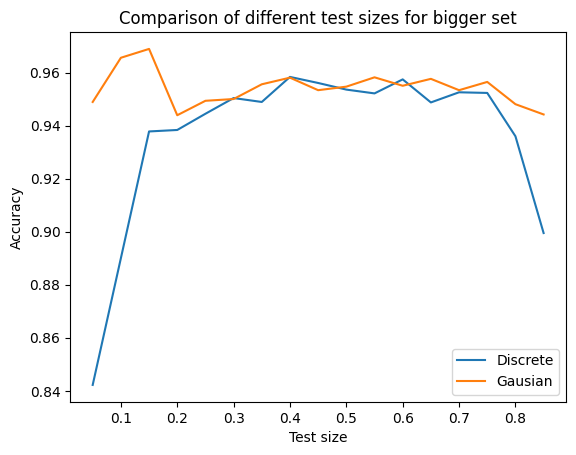

In [ ]:
test_splits = np.linspace(0.05, 0.85, num=17)
retries = 30
accuracy, gausian_accuracy = compare_algorithms_test_splits(np.concatenate((x,x), axis = 0), np.concatenate((y,y), axis = 0), test_splits, retries)
plt.plot(test_splits, accuracy/retries)
plt.plot(test_splits, gausian_accuracy/retries)
plt.xlabel("Test size")
plt.ylabel("Accuracy")
plt.legend(["Discrete", "Gausian"])
plt.title("Comparison of different test sizes for bigger set")

Jak widac powyżej dla 2 razy większego zbioru przebiegi dla dwóch kalsyfikatorów się spotykają (i średnio są większe), ale w tym wypadku Gausowski klasyfikator nie cierpi w tak dużym stopniu z małego zbioru treningowego, natomiast Dyskretny klasyfikator, później zaczyna odczuwać skutki za dużego zbioru testowego.

Co ciekawe w przedziale 0,2 do 0,7 przebiegi wydają się mniej więcej pokrywać co sugeruje że dla danych zbiorów może istnieć górna granica średniej dokładności dla klasyfikatorów naiwnych. Oczywiści ta hipoteza może być nieprawdziwa, ponieważ dla podziału 0,15 Klasyfikator Gausowski uzyskuje dokładność około 97% co jest dużo powyżej tej "granicy". Kalsyfikator Gausowski zazwyczaj jest lepszy lub równy jakości klasyfikatora bayesowskiego

Dodatkowo warto zauważyć, że średnia wartość dokładnośi dla Gausowskiego klasyfikatora nie podskoczyła aż o tak duża liczbę jak dla dyskretnego. Oznacza to że Gausowski klasyfikator może działac satysfakcjonująco również dla małych zbiorów. (barak skoku przwdopodobnie wynika z faktu że zwiększyliśmy zbiór dodając tylko te same próbki, więc średnia tak naprawde się nie zmieniła i jeżeli bysmy dodali nowe dane ten skok byłby nieco wiekszy). Na pewno podwojenie danych spowodowało, że spadek wywołny mały zbiorem treningowym ukazał sie później.

#Porównanie różnych momentów dyskretyzacji


In [ ]:
def get_accuracy_without_discretization(x_train, x_test, y_train, y_test, discretization_classes = 4):
  clasifier = NaiveBayes()
  clasifier.build_classifier(x_train, y_train, discretization_classes)
  correct_test = 0
  for x_t, y_t in zip(x_test, y_test):
    if np.argmax(clasifier.predict(x_t)) == y_t:
      correct_test += 1

  correct_train = 0
  for x_t, y_t in zip(x_train, y_train):
    if np.argmax(clasifier.predict(x_t)) == y_t:
      correct_train += 1
  return [correct_train/len(y_train), correct_test/len(y_test)]

Text(0.5, 1.0, 'Comparison of different discretization moments')

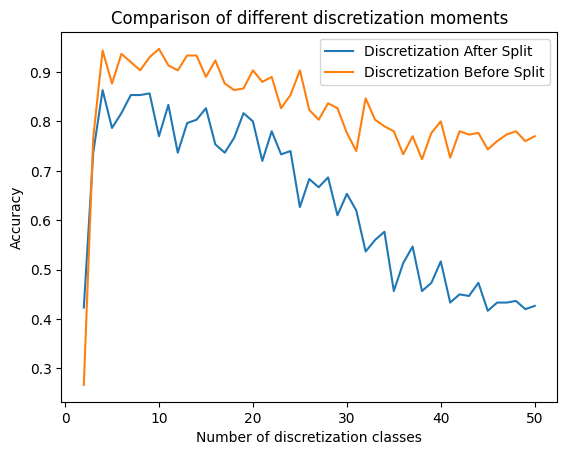

In [ ]:
max_discretization_class = 50
retries = 20
x = np.array(iris.data, copy=True)
accuracy = np.array([])
accuracy_with_discretization_before_split = np.array([])
for discretization_classes in range(2, max_discretization_class + 1):
  accuracy = np.append(accuracy, 0)
  accuracy_with_discretization_before_split = np.append(accuracy_with_discretization_before_split, 0)
  for retry in range(retries):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    accuracy[-1] += get_discreate_bayesian_naive_accuracy(x_train, x_test, y_train, y_test, discretization_classes)[1]
    x_train, x_test, y_train, y_test = train_test_split(NaiveBayes.data_discretization(x, discretization_classes), y, test_size=0.1)
    accuracy_with_discretization_before_split[-1] += get_accuracy_without_discretization(x_train, x_test, y_train, y_test, discretization_classes)[1]
plt.plot(range(2, max_discretization_class + 1), accuracy/retries)
plt.plot(range(2, max_discretization_class + 1), accuracy_with_discretization_before_split/retries)
plt.xlabel("Number of discretization classes")
plt.ylabel("Accuracy")
plt.legend(["Discretization After Split", "Discretization Before Split"])
plt.title("Comparison of different discretization moments")

#Wnioski

Klasyfikatory Bayesowskie są bardzo szybkie w uczeniu i przewidywaniu (przynajmniej na tym zbiorze), ponieważ to tylko przypisywanie odpowiednich wartości do tabeli (a nie rekurencja). Niestety tak prosta architektura ma swoje limity i przez to ciężko zaobserwować średnią dokładność równą 1. Oscylacje wyników dla dyskretnego też są dużo większe od oscylacji dla ID3, co sugeruje że ten algorytm jest dużo bardziej wrażliwy na sposób podziału zbiorów.

Ogólnie ten sposób klasyfikacji jest bardzie ciekawy i dzięki szybkości budowania i szybkości przewidywania, może byc bardzo użyteczny. Algorytm Dyskretny zyskałby na pewno gdzyby zbiór treningowy byłby starannie dobrany przez eksperta, tak aby pokryć wszystkie możeliwe ekstrema. Natomiast algorytm Gausowski bardzo zyskuje na dużej ilości elementów w zbiorze treningowym, dlatego warto w tym przypadku zadbać o dużą ilość danych zebranych do uczenia.